# Objective
Use an Artificial Neural Net to fit a model to classify hand-written digits (MNIST) with pytorch lightning.

Sources:
    
* https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09

 NOTE ON LIGHTNING!


# Setup
Import the relevant packages

In [81]:
import os
import pandas as pd
import numpy as np
import random

# packages for modelling and evaluation
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
import torch
from torch import nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
    
# packages for plotting
import matplotlib.pyplot as plt

# set a fixed random state to produce the same results
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Read Data
    
The data are given in a csv table. The first column is the label, the other coloumns are the pixels of the flattened image.

In [3]:
path = "/home/frauke/GAN/data/MNIST"
data = pd.read_csv(os.path.join(path, "train.csv"))
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Prepare the Data

In [4]:
# generate train and validation set
train_data, valid_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)
print(f'Data shape after splitting:')
print(f'Train Dataset: {train_data.shape}')
print(f'Validation Dataset: {valid_data.shape}')

Data shape after splitting:
Train Dataset: (33600, 785)
Validation Dataset: (8400, 785)


# Example Plots

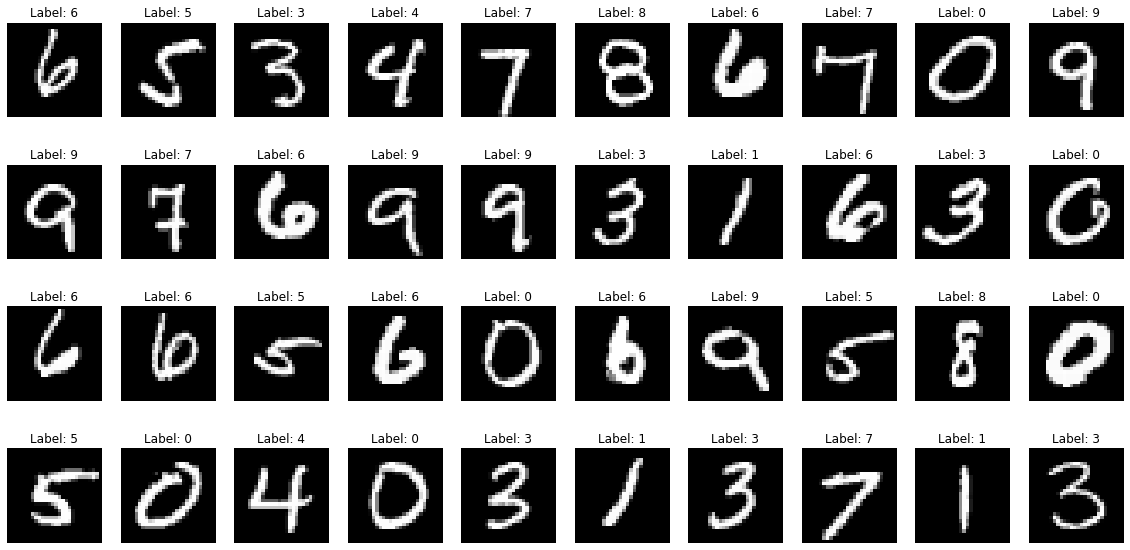

In [5]:
# first batch of validation data
X_train = train_data.iloc[:,1:].values
y_train = train_data.iloc[:,0].values

fig, axes = plt.subplots(4,10, figsize=(20,10))
    
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.axis('off')
    ax.set_title(f'Label: {int(y_train[i])}')

# Define the Dataset

**Note:**
    
For MNIST it is possible to directly download the Dataset via ```from torchvision.datasets import MNIST```. In this notebook however a dataset is constructed by hand in order to demonstrate the workflow. 
    
For more detailed information about pytorch datasets see https://github.com/utkuozbulak/pytorch-custom-dataset-examples

In [53]:
class MNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        '''
        data_frame: data as csv data frame
        transform: optional transform to be applied to a sample
        '''
        
        self.X = np.array(dataframe.iloc[:,1:]).astype(float)
        self.y = np.array(dataframe.iloc[:,0]).astype(float)
        # reshape X (#samples, #channels, width, height)
        self.X = self.X.reshape(self.X.shape[0], 28, 28, 1)
        self.transform = transform
        print(f'Data shape: X: {self.X.shape}, y: {self.y.shape}')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.transform:
            x = self.transform(x)
        return x, y

# Define the Data Module

In [54]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):#parameters):
        super().__init__()
        self.batch_size = batch_size#parameters['batch_size']
        # transforms
        self.transform = transforms.Compose([transforms.ToTensor(), 
                                             transforms.Normalize((0.1307,), (0.3081,))])

    def setup(self, stage):
        if stage == 'fit' or stage is None:
        
            self.data_frame_train = train_data
            self.data_frame_valid = valid_data
            
    def train_dataloader(self):
        # create dataset
        train_dataset = MNISTDataset(self.data_frame_train, transform=self.transform)
        # wrap dataset into dataloader
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)

        return train_dataloader
        
    def val_dataloader(self):
        # create dataset
        val_dataset = MNISTDataset(self.data_frame_valid, transform=self.transform)
        # wrap dataset into dataloader
        val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size)
        print(f'val dataloader X: {next(iter(val_dataloader))[0].shape}')
        print(f'val dataloader y: {next(iter(val_dataloader))[1].shape}')

        return val_dataloader

# Define the Model
    
This is a dense neural net using linear layers (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In [110]:
class MNISTClassifierLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):#parameters):
        super(MNISTClassifierLightning, self).__init__()
        
        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer1 = nn.Linear(28*28, 128) # in_features, out_features
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 10)
        
        self.learning_rate = learning_rate#parameters['learning_rate']
        self.accuracy = pl.metrics.Accuracy()
        
    def forward(self, x):
        
        batch_size, channels, width, height = x.size()
        
        x = x.view(batch_size, -1)
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        x = torch.log_softmax(x, dim=1)
        
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def cross_entropy_loss(self, y_hat, y):
        criterium = nn.NLLLoss()
        loss = criterium(y_hat, y) #F.nll_loss(logits, labels)
        return loss
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self.forward(x.float())
        loss = self.cross_entropy_loss(y_hat, y.long())
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_accuracy', acc, on_step=False, on_epoch=True)
        return loss
        
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.forward(x.float())
        loss = self.cross_entropy_loss(y_hat, y.long())
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_accuracy', acc, on_epoch=True)

# Callbacks

In [111]:
class MNISTCallbacks(Callback):
    def __init__(self):
        super().__init__()

    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        print(f'\nValidation epoch {epoch} end:')
        for key, item in metrics.items():
            print(f'{key}: {item:.4f}')

# Train the Model

In [112]:
# hyperparamters 
max_epochs = 5
#'device': 'cpu',

model = MNISTClassifierLightning(learning_rate=1e-3)#.to(device)
data_module = MNISTDataModule(batch_size=32)
trainer = pl.Trainer(max_epochs=parameters['epochs'], callbacks=[MNISTCallbacks()])
trainer.fit(model, data_module)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type     | Params
--------------------------------------
0 | layer1   | Linear   | 100 K 
1 | layer2   | Linear   | 33.0 K
2 | layer3   | Linear   | 2.6 K 
3 | accuracy | Accuracy | 0     
--------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params


Data shape: X: (8400, 28, 28, 1), y: (8400,)
val dataloader X: torch.Size([32, 1, 28, 28])
val dataloader y: torch.Size([32])
Validation sanity check: 0it [00:00, ?it/s]
Validation epoch 0 end:
val_loss: 42.6596
val_accuracy: 0.0938
Data shape: X: (33600, 28, 28, 1), y: (33600,)
Epoch 0:   0%|          | 3/1313 [00:00<00:23, 56.20it/s, loss=34.3, v_num=26]

/home/frauke/anaconda3/envs/lightning_env/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/frauke/anaconda3/envs/lightning_env/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validating:  91%|█████████ | 239/263 [00:00<00:00, 306.22it/s]
Validation epoch 0 end:
val_loss: 0.4040
val_accuracy: 0.9079
Epoch 1:  80%|███████▉  | 1050/1313 [00:14<00:03, 73.19it/s, loss=0.416, v_num=26] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▊| 1296/1313 [00:15<00:00, 84.09it/s, loss=0.416, v_num=26]
Validation epoch 1 end:
val_loss: 0.3651
val_accuracy: 0.9182
train_loss: 0.9320
train_accuracy: 0.8549
Epoch 2:  80%|███████▉  | 1050/1313 [00:16<00:04, 65.21it/s, loss=0.289, v_num=26]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▊| 1296/1313 [00:17<00:00, 75.93it/s, loss=0.289, v_num=26]
Validation epoch 2 end:
val_loss: 0.2660
val_accuracy: 0.9312
train_loss: 0.3712
train_accuracy: 0.9128
Epoch 3:  80%|███████▉  | 1050/1313 [00:16<00:04, 62.79it/s, loss=0.175, v_num=26]
Validating: 0it [00:00, ?it/s]
Validating:  94%|█████████▍| 247/263 [00:00<00:00, 261.88it/s]
Validation epoch 3 end:
val_loss: 0.2945
val_accuracy: 0.9285
train_loss: 0.2755
train_accuracy

1